In [1]:
from glob import glob
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy import stats
from scipy.ndimage import binary_dilation  
from astropy.modeling import models, fitting
import numpy as np
from astropy.modeling import models, fitting
from reproject import reproject_interp
import time 
import warnings 
warnings.filterwarnings('ignore')

def fit_2d_gaussian_and_get_sum(image):

    image = np.squeeze(image)
    image[np.isnan(image)] = 0

    # Get the center of the image
    shape_x, shape_y = image.shape
    center_x, center_y = np.array(image.shape) // 2
    
    # Create x, y indices grid for the sub-image
    x, y = np.array(np.mgrid[:shape_x, :shape_y], dtype=np.int32)
    
    # Initialize the Gaussian2D model
    g_init = models.Gaussian2D(amplitude=np.nanmax(image), x_mean=center_x, y_mean=center_y)
    
    # Fit the model to the sub-image
    fit_g = fitting.LevMarLSQFitter()
    g = fit_g(g_init, x, y, image)
    
    # Calculate the sum of the fitted Gaussian
    fitted_data = np.array(g(x, y), dtype=np.float32)
    gaussian_sum = np.sum(fitted_data)
    
    return (gaussian_sum*u.Jy, fitted_data)

def remove_padding(data):
    
    # Find valid data indices along each axis
    valid_x = np.where(np.nansum(data, axis=0)!=0)[0]
    valid_y = np.where(np.nansum(data, axis=1)!=0)[0]

    # In the rare case there's still no valid data
    if len(valid_x) == 0 or len(valid_y) == 0:
        return data
    
    # Crop the data array
    cropped_data = data[valid_y[0]:valid_y[-1]+1, valid_x[0]:valid_x[-1]+1]
    return cropped_data

def remove_padding_2arrays(data1, data2):
    
    # Find valid data indices along each axis
    valid_x = np.where(np.nansum(data1, axis=0)!=0)[0]
    valid_y = np.where(np.nansum(data1, axis=1)!=0)[0]

    # In the rare case there's still no valid data
    if len(valid_x) == 0 or len(valid_y) == 0:
        return data1
    
    # Crop the data array
    cropped_data = data2[valid_y[0]:valid_y[-1]+1, valid_x[0]:valid_x[-1]+1]
    return cropped_data

which = 'gaussians'

# which_time = ''
which_time = '_6totaltime'
# which_time = '_60totaltime'
# which_time = '_6totaltime_flagged'
# which_time = '_60totaltime_flagged'

dir_sim = f'./../data/{which}_input/'
dir_obs = f'./../data/{which}_observed{which_time}/'

files_sim = glob(f'{dir_sim}*.fits')
files_obs = glob(f'{dir_obs}*.pbcor.Jyperpix.fits')

files_sim.sort()
files_obs.sort()

confs = ['conf1']
count = 0

start_total = time.time()
for conf in confs: 

    files_sim = glob(f'{dir_sim}{conf}_*.fits')
    files_obs = glob(f'{dir_obs}{conf}_*.pbcor.Jyperpix.fits')
    files_sim.sort()
    files_obs.sort()

    n = 15
    max_sim = ['']*n
    max_obs = ['']*n
    sum_sim = ['']*n
    sum_obs = ['']*n
    sum_mask10_obs = ['']*n
    sum_mask10_sim = ['']*n
    sum_mask50_obs = ['']*n
    sum_mask50_sim = ['']*n
    sum_fit_sim = ['']*n
    sum_fit_obs = ['']*n
    rms_arr = ['']*n
    conf_arr = ['']*n
    wide_arr = ['']*n

    for i, file_sim in enumerate(files_sim):
        
        start = time.time()

        conf_file = file_sim.split('/')[-1].split('_')[0]
        wide_file = file_sim.split('/')[-1].split('_')[-1].replace('.fits', '')
        
        for file_obs in files_obs:
            if (conf_file in file_obs) & (wide_file in file_obs):

                if conf_file != conf: 
                    continue

                if '2.9mrs' not in wide_file:
                    continue

                # if count>0:
                #     continue
                # count+=1

                conf_arr[i] = conf
                wide_arr[i] = wide_file

                print('%s' %file_sim.split('/')[-1])
                print('%s' %file_obs.split('/')[-1])

file_sim = './../data/gaussians_input/conf1_2.9mrs0.fits'
file_obs = './../data/gaussians_observed_6totaltime/conf1_2.9mrs0_project_6totaltime.alma.cycle5.1.image.pbcor.Jyperpix.fits'

conf1_2.9mrs0.fits
conf1_2.9mrs0_project_6totaltime.alma.cycle5.1.image.pbcor.Jyperpix.fits


In [2]:
hdu_sim = fits.open(file_sim)[0]
hdu_obs = fits.open(file_obs)[0]

hdu_sim.data = np.array(hdu_sim.data, dtype=np.float32)
hdu_obs.data = np.array(hdu_obs.data, dtype=np.float32)

print('[INFO] Getting squeeze...')
data_sim = np.array(np.squeeze(hdu_sim.data.copy()), dtype=np.float32)
data_obs = np.array(np.squeeze(hdu_obs.data.copy()), dtype=np.float32)

print('[INFO] Getting cropping...')
data_sim = remove_padding(data_sim)
data_obs = remove_padding(data_obs)

[INFO] Getting squeeze...
[INFO] Getting cropping...


In [3]:
data_obs.shape, data_sim.shape

((245, 239), (73, 73))

In [4]:
hdu_sim.data = np.squeeze(hdu_sim.data)
hdu_obs.data = data_obs

hdu_obs.header['CRPIX1'] = hdu_obs.data.shape[1]/2
hdu_obs.header['CRPIX2'] = hdu_obs.data.shape[0]/2
del hdu_sim.header['*3*']
del hdu_sim.header['*4*']
del hdu_obs.header['*3*']
del hdu_obs.header['*4*']
del hdu_obs.header['*PC*']
del hdu_sim.header['*PC*']

data_sim_r, _ = np.array(reproject_interp(hdu_sim, hdu_obs.header), dtype=np.float32)
data_sim_rp = remove_padding(data_sim_r)

In [5]:
# fits.PrimaryHDU(data_sim, hdu_sim.header).writeto('tmp1.fits')
# fits.PrimaryHDU(data_obs, hdu_sim.header).writeto('tmp2.fits')
# fits.PrimaryHDU(data_sim_r, hdu_sim.header).writeto('tmp3.fits')
# fits.PrimaryHDU(data_sim_rp, hdu_sim.header).writeto('tmp4.fits')

In [6]:
data_obs.shape, data_sim.shape, data_sim_r.shape, data_sim_rp.shape

((245, 239), (73, 73), (245, 239), (52, 52))

In [7]:
if np.squeeze(data_sim_rp).shape[0] < data_obs.shape[0]:
    print('[INFO] Getting cropping - data to sim...')
    data_obs = np.array(np.squeeze(hdu_obs.data.copy()), dtype=np.float32)
    data_obs = remove_padding_2arrays(np.squeeze(data_sim_r), data_obs)
    print('[INFO] Time to run data to sim cropping: %0.2f [sec]' %((time.time() - start)))

[INFO] Getting cropping - data to sim...
[INFO] Time to run data to sim cropping: 4.32 [sec]


In [8]:
data_obs.shape

(52, 52)

In [9]:
def fit_2d_gaussian_and_get_sum(image, x_stddev=None, y_stddev=None):

    image = np.squeeze(image)
    image[np.isnan(image)] = 0

    # Get the center of the image
    shape_x, shape_y = image.shape
    center_x, center_y = np.array(image.shape) // 2
    
    # Create x, y indices grid for the sub-image
    x, y = np.array(np.mgrid[:shape_x, :shape_y], dtype=np.int32)
    
    # Initialize the Gaussian2D model
    g_init = models.Gaussian2D(amplitude=np.nanmax(image), 
                               x_mean=center_x, y_mean=center_y, 
                               x_stddev=x_stddev, y_stddev=y_stddev)
    
    # Fit the model to the sub-image
    fit_g = fitting.LevMarLSQFitter()
    g = fit_g(g_init, x, y, image)
    
    # Calculate the sum of the fitted Gaussian
    fitted_data = np.array(g(x, y), dtype=np.float32)
    gaussian_sum = np.sum(fitted_data)
    
    return (gaussian_sum*u.Jy, fitted_data, g)

In [10]:
sum_fit_sim, fitted_data_sim, g = fit_2d_gaussian_and_get_sum(data_sim)
sum_fit_obs, fitted_data_obs, g = fit_2d_gaussian_and_get_sum(data_obs) 
print(sum_fit_obs)

sum_fit_obs, fitted_data_obs, g = fit_2d_gaussian_and_get_sum(data_obs, g.x_stddev.value, g.y_stddev.value) 

print(sum_fit_sim)
print(sum_fit_obs)

36.997032165527344 Jy
39.468482971191406 Jy
36.99703598022461 Jy


In [11]:
import numpy as np
from astropy.modeling import models, fitting
import astropy.units as u
import numpy as np
from scipy.integrate import dblquad

def empirical_gaussian_sum(amplitude, x_mean, y_mean, x_stddev, y_stddev, x_min, x_max, y_min, y_max):

    gaussian_func = lambda x, y: amplitude * np.exp(-((x - x_mean)**2 / (2 * x_stddev**2) + (y - y_mean)**2 / (2 * y_stddev**2)))
    empirical_sum, _ = dblquad(gaussian_func, x_min, x_max, lambda x: y_min, lambda x: y_max)

    return empirical_sum

def fit_2d_gaussian_and_get_sum_with_uncertainty(image):
    image = np.squeeze(image)
    image[np.isnan(image)] = 0

    # Get the center of the image
    shape_x, shape_y = image.shape
    center_x, center_y = np.array(image.shape) // 2

    # Create x, y indices grid for the sub-image
    x, y = np.array(np.mgrid[:shape_x, :shape_y], dtype=np.int32)

    # Initialize the Gaussian2D model
    g_init = models.Gaussian2D(amplitude=np.nanmax(image), x_mean=center_x, y_mean=center_y)

    # Fit the model to the sub-image
    fit_g = fitting.LevMarLSQFitter()
    g = fit_g(g_init, x, y, image)

    start = time.time()
    # Calculate the sum of the fitted Gaussian
    fitted_data = np.array(g(x, y), dtype=np.float32)
    gaussian_sum = np.sum(fitted_data)
    end = time.time()
    print(end - start)
    
    # Calculate the uncertainty on the fit using the covariance matrix
    cov_matrix = fit_g.fit_info['param_cov']
    if cov_matrix is not None:
        g_err = np.sqrt(np.diag(cov_matrix))
    else:
        g_err = np.zeros_like(g.parameters)

    amplitude = g.amplitude.value
    x_mean = g.x_mean.value
    y_mean = g.y_mean.value
    x_stddev = g.x_stddev.value
    y_stddev = g.y_stddev.value
    x_min, x_max, y_min, y_max = 0, shape_x, 0, shape_y

    start = time.time()
    gaussian_intsum = empirical_gaussian_sum(amplitude, x_mean, y_mean, x_stddev, y_stddev, x_min, x_max, y_min, y_max)
    end = time.time()
    print(end - start)

    gaussian_intsuml = empirical_gaussian_sum(amplitude-g_err[0], x_mean-g_err[1], y_mean-g_err[2], x_stddev-g_err[3], y_stddev-g_err[4], x_min, x_max, y_min, y_max)
    gaussian_intsumh = empirical_gaussian_sum(amplitude+g_err[0], x_mean+g_err[1], y_mean+g_err[2], x_stddev+g_err[3], y_stddev+g_err[4], x_min, x_max, y_min, y_max)

    # Return the result along with the uncertainty
    return (gaussian_sum * u.Jy, (gaussian_intsum, gaussian_intsuml, gaussian_intsumh))

sum_fit_sim, err_fit_sim = fit_2d_gaussian_and_get_sum_with_uncertainty(data_sim)
sum_fit_obs, err_fit_obs = fit_2d_gaussian_and_get_sum_with_uncertainty(data_obs) 

0.00017881393432617188
0.06625103950500488
0.0001277923583984375
0.032321929931640625


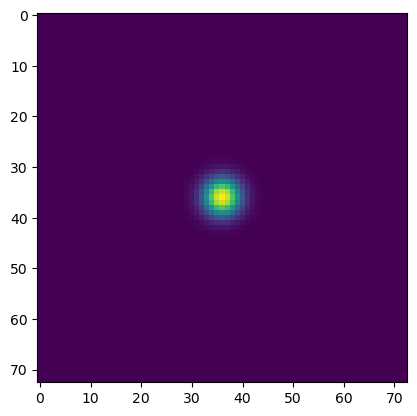

In [17]:
from matplotlib import pyplot as plt

plt.imshow(data_sim)

In [15]:
import numpy as np
from scipy.integrate import dblquad

def empirical_gaussian_sum(amplitude, x_mean, y_mean, x_stddev, y_stddev, x_min, x_max, y_min, y_max):
    """
    Empirically calculates the sum of a 2D Gaussian over a given region.

    Parameters:
    amplitude : float
        Amplitude of the Gaussian.
    x_mean, y_mean : float
        Mean values of the Gaussian in the x and y directions.
    x_stddev, y_stddev : float
        Standard deviations of the Gaussian in the x and y directions.
    x_min, x_max, y_min, y_max : float
        Integration limits for x and y.

    Returns:
    float
        Empirical sum of the Gaussian over the specified region.
    """
    gaussian_func = lambda x, y: amplitude * np.exp(-((x - x_mean)**2 / (2 * x_stddev**2) + (y - y_mean)**2 / (2 * y_stddev**2)))

    empirical_sum, _ = dblquad(gaussian_func, x_min, x_max, lambda x: y_min, lambda x: y_max)

    return empirical_sum

image = data_sim

amplitude = g.amplitude.value
x_mean = g.x_mean.value
y_mean = g.y_mean.value
x_stddev = g.x_stddev.value
y_stddev = g.y_stddev.value

shape_x, shape_y = image.shape
center_x, center_y = np.array(image.shape) // 2

x_min, x_max, y_min, y_max = 0, shape_x, 0, shape_y

start = time.time()
result = empirical_gaussian_sum(amplitude, x_mean, y_mean, x_stddev, y_stddev, x_min, x_max, y_min, y_max)
end = time.time()
print(end - start)

print(f"Empirical Gaussian Sum: {result}")
print(f"Sum: {np.sum(image)}")
print(f"Empirical Gaussian Ratio: {result/np.sum(image)}")

0.05269598960876465
Empirical Gaussian Sum: 36.99703546307869
Sum: 39.468482971191406
Empirical Gaussian Ratio: 0.9373817455837696


In [13]:
amplitude = 1
x_mean = 5e6
y_mean = 5e6
x_stddev = 1e6
y_stddev = 1e6

x_min, x_max, y_min, y_max = 0, 1e7, 0, 1e7

start = time.time()
result = empirical_gaussian_sum(amplitude, x_mean, y_mean, x_stddev, y_stddev, x_min, x_max, y_min, y_max)
end = time.time()
print(end - start)

print(f"Empirical Gaussian Sum: {result}")

0.010702133178710938
Empirical Gaussian Sum: 6283178102841.875


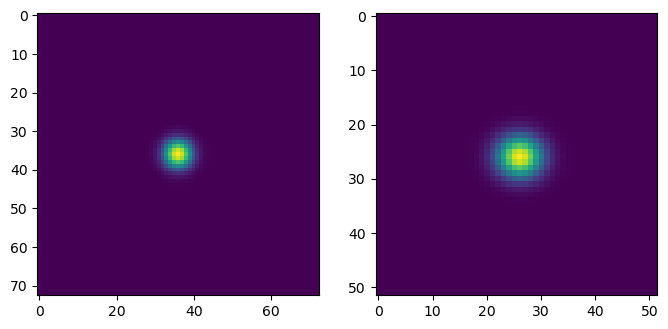

In [14]:
from matplotlib import pyplot as plt

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

ax1.imshow(fitted_data_sim)
ax2.imshow(fitted_data_obs)

fits.PrimaryHDU(fitted_data_sim, hdu_sim.header).writeto('fitted_data_sim.fits', overwrite=True)
fits.PrimaryHDU(fitted_data_obs, hdu_sim.header).writeto('fitted_data_obs.fits', overwrite=True)
fits.PrimaryHDU(data_sim, hdu_sim.header).writeto('data_sim.fits', overwrite=True)
fits.PrimaryHDU(data_obs, hdu_sim.header).writeto('data_obs.fits', overwrite=True)

In [11]:
i = 0

print('[INFO] Getting sums...')
rms_sim = 0  
rms_obs = stats.mad_std(data_obs, ignore_nan=True)
rms_obs = stats.mad_std(data_obs[data_obs<rms_obs], ignore_nan=True)
rms_arr[i] = rms_obs*u.Jy

mask_high = data_obs == np.nanmax(data_obs)
mask_low = data_obs > rms_obs*3
mask = binary_dilation(mask_high, mask=mask_low, iterations=-1)

# mask_hdu = fits.PrimaryHDU(mask*np.int32(1), fits.getheader(file_obs))
# mask_hdu.writeto(file_obs.replace('.Jyperpix.fits', '.Jyperpix.mask.fits'), overwrite=True)

max_sim[i] = np.nanmax(data_sim)*u.Jy
max_obs[i] = np.nanmax(data_obs)*u.Jy

sum_sim[i] = np.nansum(data_sim)*u.Jy
sum_obs[i] = np.nansum(data_obs[mask])*u.Jy
print('[INFO] Time to run sums: %0.2f [sec]' %((time.time() - start)))

print('[INFO] Getting fits...')
sum_fit_sim[i], fitted_data_sim = fit_2d_gaussian_and_get_sum(data_sim)
print('[INFO] Time to run sim fit: %0.2f [sec]' %((time.time() - start)))
sum_fit_obs[i], fitted_data_obs = fit_2d_gaussian_and_get_sum(data_obs) 
print('[INFO] Time to run obs fit: %0.2f [sec]' %((time.time() - start)))

print('[INFO] Getting masked sums...')
### Get masked flux
mask_sim = data_sim/np.nanmax(data_sim) > 0.1
mask_sim_r = data_sim_rp/np.nanmax(data_sim_rp) > 0.1

sum_mask10_sim[i] = np.nansum(data_sim[mask_sim])*u.Jy
sum_mask10_obs[i] = np.nansum(data_obs[mask_sim_r])*u.Jy

mask_sim = data_sim/np.nanmax(data_sim) > 0.5
mask_sim_r = data_sim_rp/np.nanmax(data_sim_rp) > 0.5

sum_mask50_sim[i] = np.nansum(data_sim[mask_sim])*u.Jy
sum_mask50_obs[i] = np.nansum(data_obs[mask_sim_r])*u.Jy
print('[INFO] Time to run masked sums: %0.2f [sec]' %((time.time() - start)))

[INFO] Getting sums...
[INFO] Time to run sums: 7.42 [sec]
[INFO] Getting fits...


ValueError: too many values to unpack (expected 2)

In [ ]:
sum_mask10_sim[i], sum_mask10_obs[i]

In [ ]:
sum_sim[i], sum_fit_sim[i], sum_fit_obs[i]